In [1]:
%reset -sf
import torch
from torch.utils.checkpoint import checkpoint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
from opt_einsum import contract
def _toN(t):
    return t.detach().cpu().numpy()
def printDiff(name,value,ref):
    if ref is not None:
        print(name+':',value,'diff(abs):',value-ref)
    else:
        print(name+':',value)

# SRG BaseClass

In [2]:
class SRG(torch.nn.Module):
    def __init__(self,params,options):
        super(SRG,self).__init__()
        self.dtype=options.get('dtype',torch.float64)
        self.device=options.get('device','cpu')
        self.max_dim=options.get('max_dim',16)
        self.nLayers=options.get('nLayers',10)
        self.use_checkpoint=options.get('use_checkpoint',True)
        self.observable_checkerboard=False
        
        self.params=torch.nn.ParameterDict({
            k:torch.nn.Parameter(torch.tensor(v,dtype=self.dtype,device=self.device)) for k,v in params.items()
        })
        self.current_logZ=0
        
    def __str__(self):
        rtval=""
        for k,v in self.params.items():
            rtval+=k+':'+v+'\n'
        rtval+='dtype:'+self.dtype+'\n'
        rtval+='device:'+self.device+'\n'
        rtval+='max_dim:'+self.max_dim+'\n'
        rtval+='nLayers:'+self.nLayers+'\n'
        rtval+='nSite:'+2**nLayers+'\n'
    def toT(self,t):
        return torch.tensor(t,dtype=self.dtype,device=self.device)
    def generate_random_Isometry(self,dim1,dim2):
        dim=max(dim1,dim2)
        A=torch.randn(dim,dim,dtype=self.dtype,device=self.device)
        U=torch.matrix_exp(A-A.t())
        U=U[:dim1,:dim2]
        return U
    
    def TRG_same_T(self,T,*w):
        return self.TRG(T,T,*w)
    
    def forward_tensor(self):
        logTotal=0
        T=self.get_T0()
        for i in range(self.nLayers):
            w=self.ws[(i*self.w_per_layer):((i+1)*self.w_per_layer)]
            if self.use_checkpoint:
                T=torch.utils.checkpoint.checkpoint(self.TRG_same_T,T,*w)
            else:
                T=self.TRG_same_T(T,*w)
                
            norm=torch.linalg.norm(T)
            T=T/norm
            logTotal=2*logTotal+torch.log(norm)
        return T,logTotal
    
    def forward_tensor_with_observable(self,T_op):
        logTotal=0
        T=self.get_T0()
        for i in range(self.nLayers):
            w=self.ws[(i*self.w_per_layer):((i+1)*self.w_per_layer)]
            if self.use_checkpoint:
                T1=torch.utils.checkpoint.checkpoint(self.TRG_same_T,T,*w)
                T2=torch.utils.checkpoint.checkpoint(self.TRG,T,T_op,*w)
                T3=torch.utils.checkpoint.checkpoint(self.TRG,T_op,T,*w)
            else:
                T1=self.TRG_same_T(T,*w)
                T2=self.TRG(T,T_op,*w)
                T3=self.TRG(T_op,T,*w)
            if self.observable_checkerboard and i<self.spacial_dim:
                T3=-T3

            T,T_op=T1,(T2+T3)/2
            norm=torch.linalg.norm(T)
            T,T_op=T/norm,T_op/norm
            logTotal=2*logTotal+torch.log(norm)
        return T,T_op,logTotal
    
    
    def dlogZ(self,param):
        self.requires_grad_(False)
        self.params[param].requires_grad_(True)
        self.zero_grad()
        logZ=self.forward()
        logZ.backward()
        result=_toN(self.params[param].grad)
        self.params[param].requires_grad_(False)
        return result
    
    def update_single_layer(self,layer):
        self.requires_grad_(False)
        
        for i in range(layer*self.w_per_layer,(layer+1)*self.w_per_layer):
            self.ws[i].requires_grad_(True)
        self.zero_grad()
        
        logZ=self.forward()
        logZ.backward()
        
        with torch.no_grad():
            for i in range(layer*self.w_per_layer,(layer+1)*self.w_per_layer):
                E=self.ws[i].grad
                dim1,dim2=E.shape[0],E.shape[2]
                E=E.reshape(dim1*dim1,dim2)
                U,S,Vh=torch.linalg.svd(E,full_matrices=False)
                UVh=U@Vh
                del U,S,Vh
                #UVh=svd2UVh(E)
                self.ws[i].data=UVh.reshape(dim1,dim1,dim2)
                del E,UVh
                
        torch.cuda.empty_cache()
        self.current_logZ=_toN(logZ)
        
    def optimize(self,nIter,ref_logZ=None):
        torch.cuda.empty_cache()
        if nIter>1:
            pbar2=tqdm(range(nIter), leave=False)
            pbar2.set_postfix({k:_toN(v) for k,v in self.params.items()})
        else:
            pbar2=range(nIter)
        for i in pbar2:
            pbar=tqdm(range(self.nLayers-1,-1,-1), leave=False)
            for j in pbar:
                self.update_single_layer(j)
                if ref_logZ is not None:
                    pbar.set_postfix({"diff":self.current_logZ-ref_logZ})
                else:
                    pbar.set_postfix({"logZ":self.current_logZ})
                torch.cuda.empty_cache()
        #printDiff('logZ',toN(forward(params,ws)),ref_logZ)
        torch.cuda.empty_cache()
        #lock all grads
        for param in self.params.values(): 
            param.requires_grad_(False)
        for i in range(self.nLayers): #slightly faster
            self.ws[i].requires_grad_(False)

In [3]:
class HOTRG(SRG):
    def __init__(self,params,options):
        super(HOTRG,self).__init__(params,options)
    
    def create_params(self,start_dim,spacial_dim):
        ws=[]
        bond_dim=[start_dim]*spacial_dim
        for i in range(self.nLayers):
            for j in range(1,spacial_dim):
                old_dim=bond_dim[j]
                new_dim=min(old_dim**2,self.max_dim)
                U=self.generate_random_Isometry(old_dim**2,new_dim).view(old_dim,old_dim,new_dim)
                ws.append(U.detach())
                bond_dim[j]=new_dim
            bond_dim=bond_dim[1:]+[bond_dim[0]]
        self.ws=torch.nn.ParameterList([
            torch.nn.Parameter(v) for v in ws
        ])
        self.w_per_layer=spacial_dim-1
        self.spacial_dim=spacial_dim
        
    def HOTRG2D(self,T1,T2,w):
        return contract('ijkl,jmno,kna,lob->abim',T1,T2,w,w)#contract and rotate
    
    def HOTRG3D(self,T1,T2,w1,w2):
        return contract('ijklmn,jopqrs,kpa,lqb,mrc,nsd->abcdio',T1,T2,w1,w1,w2,w2)#contract and rotate
    
    def forward(self):
        T,logTotal=self.forward_tensor()
        contract_all=[i for i in range(len(T.shape)//2) for j in range(2)]
        Z=contract(T,contract_all)
        return (torch.log(Z)+logTotal)/2**self.nLayers
    
    def forward_with_observable(self,T_op):
        T,T_op,_=self.forward_tensor_with_observable(T_op)
        contract_all=[i for i in range(len(T.shape)//2) for j in range(2)]
        Z=contract(T,contract_all)
        Z_op=contract(T_op,contract_all)
        return Z_op/Z

# AKLT 2D

In [4]:
from scipy.special import comb
def get_CG_no_normalization(n):
    if n==0:
        return np.eye(1)
    CG=np.zeros((n+1,)+(2,)*n)
    for i in range(2**n):
        indices=tuple(map(int,bin(i)[2:].zfill(n)))
        m=np.sum(indices)
        CG[(m,)+indices]=1
    return CG
def get_CG(n):
    if n==0:
        return np.eye(1)
    CG=np.zeros((n+1,)+(2,)*n)
    for i in range(2**n):
        indices=tuple(map(int,bin(i)[2:].zfill(n)))
        m=np.sum(indices)
        CG[(m,)+indices]=1/np.sqrt(comb(n,m))
    return CG
def get_Singlet():
    return np.array([[0,1.],[-1.,0]])

print(get_CG_no_normalization(4).reshape(5,-1))
print(get_CG(3).reshape(4,-1))
assert get_CG(3).shape==(4,2,2,2)
assert np.isclose(get_CG(3).reshape(4,-1)@get_CG(3).reshape(4,-1).T,torch.eye(4)).all()
print(get_Singlet())
assert np.isclose(get_Singlet()@get_Singlet(),-torch.eye(2)).all()
assert (get_Singlet()==-get_Singlet().T).all()

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[1.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.57735027 0.57735027 0.         0.57735027 0.
  0.         0.        ]
 [0.         0.         0.         0.57735027 0.         0.57735027
  0.57735027 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         1.        ]]
[[ 0.  1.]
 [-1.  0.]]


In [13]:
class AKLT2D(HOTRG): # manual contract first two level
    def __init__(self,params,options):
        super(AKLT2D,self).__init__(params,options)
        self.create_params(start_dim=16,spacial_dim=2)
        self.TRG=self.HOTRG2D
        
    def get_T0_sub(self):
        projector=self.toT(get_CG_no_normalization(4))
        singlet=self.toT([[0,-1],[1,0]])
        ac0,ac1,ac2=self.toT(1),self.params['a1'],self.params['a2']
        deform=torch.stack([ac2,ac1,ac0,ac1,ac2])
        node=contract('aijkl,im,kn,a->amjnl',projector,singlet,singlet,deform)
        return contract('aijkl,amnop->imjnkolp',node,node).reshape(4,4,4,4)#UDLR

    def get_SZT0_sub(self):
        projector=self.toT(get_CG_no_normalization(4))
        singlet=self.toT([[0,-1],[1,0]])
        ac0,ac1,ac2=self.toT(1),self.params['a1'],self.params['a2']
        deform=torch.stack([ac2,ac1,ac0,ac1,ac2])
        node=contract('aijkl,im,kn,a->amjnl',projector,singlet,singlet,deform)
        op=self.toT([2,1,0,-1,-2])
        return contract('aijkl,amnop,a->imjnkolp',node,node,op).reshape(4,4,4,4)#UDLR
    
    def get_T0(self):
        t0=self.get_T0_sub()
        t1=contract('ijab,jkcd->ikacbd',t0,t0)
        t2=contract('ijabcd,klcdef->ikjlabef',t1,t1).reshape(16,16,16,16)
        return t2
    
    def get_SZT0(self):
        t0,s0=self.get_T0_sub(),self.get_SZT0_sub()
        t1=contract('ijab,jkcd->ikacbd',t0,t0)
        s1=(contract('ijab,jkcd->ikacbd',s0,t0)-contract('ijab,jkcd->ikacbd',t0,s0))/2
        s2=(contract('ijabcd,klcdef->ikjlabef',s1,t1)-contract('ijabcd,klcdef->ikjlabef',t1,s1)).reshape(16,16,16,16)/2
        return s2
    
    def get_magnetization(self):
        with torch.no_grad():
            return _toN(torch.abs(self.forward_with_observable(self.get_SZT0())))

In [14]:
class AKLT2D(HOTRG):
    def __init__(self,params,options):
        super(AKLT2D,self).__init__(params,options)
        self.create_params(start_dim=4,spacial_dim=2)
        self.TRG=self.HOTRG2D
        self.observable_checkerboard=True
        
    def get_T0(self):
        projector=self.toT(get_CG_no_normalization(4))
        singlet=self.toT([[0,-1],[1,0]])
        ac0,ac1,ac2=self.toT(1),self.params['a1'],self.params['a2']
        deform=torch.stack([ac2,ac1,ac0,ac1,ac2])
        node=contract('aijkl,im,kn,a->amjnl',projector,singlet,singlet,deform)
        return contract('aijkl,amnop->imjnkolp',node,node).reshape(4,4,4,4)#UDLR

    def get_SZT0(self):
        projector=self.toT(get_CG_no_normalization(4))
        singlet=self.toT([[0,-1],[1,0]])
        ac0,ac1,ac2=self.toT(1),self.params['a1'],self.params['a2']
        deform=torch.stack([ac2,ac1,ac0,ac1,ac2])
        node=contract('aijkl,im,kn,a->amjnl',projector,singlet,singlet,deform)
        op=self.toT([2,1,0,-1,-2])
        return contract('aijkl,amnop,a->imjnkolp',node,node,op).reshape(4,4,4,4)#UDLR
    
    def get_magnetization(self):
        with torch.no_grad():
            return _toN(torch.abs(self.forward_with_observable(self.get_SZT0())))

# AKLT Test

{'dtype': torch.float32, 'device': 'cuda:0', 'max_dim': 30, 'nLayers': 30, 'use_checkpoint': True}
{'a1': 0, 'a2': 3}


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

C:\Anaconda3\envs\tensorflow\lib\site-packages\torch\utils\checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


a1 : 0 a2 : 3 iter : 1 logZ : 2.1973217 magnetization : 1.9985821 


  0%|          | 0/30 [00:00<?, ?it/s]

a1 : 0 a2 : 3 iter : 2 logZ : 2.197384 magnetization : 1.9986666 


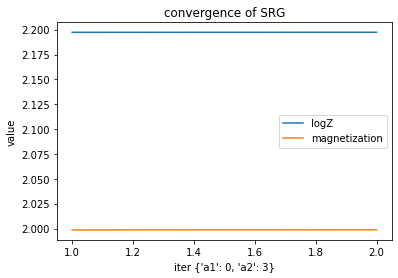

In [17]:
options={
    'dtype':torch.float32,
    'device':'cuda:0',
    'max_dim':30,
    'nLayers':30,
    'use_checkpoint':True
}
params={'a1':np.sqrt(6)/2,'a2':np.sqrt(6)}
params['a1']=0
params['a2']=3
srg=AKLT2D(params,options)
print(options)
print(params)

data=pd.DataFrame()
for i in tqdm(range(2)):
    srg.optimize(1)
    num_iter=i+1
    newRow={'a1':params['a1'],'a2':params['a2'],'iter':num_iter,'logZ':srg.current_logZ,'magnetization':srg.get_magnetization()}
    for k,v in newRow.items():
        print(k,':',v,end=' ')
    print()
    data=data.append(newRow,ignore_index=True)

plt.plot(data['iter'],data['logZ'])
plt.plot(data['iter'],np.abs(data['magnetization']))
plt.xlabel(f'iter {params}')
plt.ylabel('value')
plt.legend(['logZ','magnetization'])
plt.title('convergence of SRG')
plt.show()
